## 1.  Define the Mnist-SNN Network Architecture 

In [41]:
import snntorch as snn

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np


# DataLoader Arguments
batch_size = 128
data_path = '/data/mnist'

dtype = torch.float
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Select Dataset and define Transform
transform = transforms.Compose([transforms.Resize((10, 10)),
                                transforms.Grayscale(),
                                transforms.ToTensor(),
                                transforms.Normalize((0,), (1,))])

mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
indices = (mnist_test.targets == 0) | (mnist_test.targets == 1) | (mnist_test.targets == 2) | (mnist_test.targets == 3) 
mnist_test.data, mnist_test.targets = mnist_test.data[indices], mnist_test.targets[indices]

# print(f"The size of test_set is {len(mnist_test)}")      # 4157

# Create DataLoaders, load multiple samples up into memory in batches
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

# Define the network
num_inputs = 10*10  
num_hidden = 200
num_outputs = 4   # 4 outputs classes: 0, 1, 2, 3

# Temporal Dynamics
num_steps = 10      # run for 10 time steps
beta = 0.95 

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initialize layers
        # Neuron input: Spik_in W x X[t] and U[t-1], Neuron output: Spike S[t] and U[t]
        self.lif1 = snn.Leaky(beta=beta, threshold=0.001)  # Threshold=0.001: each raw image pixel value greater than 0 corresponds to a spike
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif2 = snn.Leaky(beta=beta, threshold=0.1)  
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif3 = snn.Leaky(beta=beta, threshold=0.7)
        
    def forward(self, x):
        
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        
        # Record the finial laye
#         spk1_rec = []
#         mem1_rec = []
#         spk2_rec = []
#         mem2_rec = []
        spk3_rec = []
        mem3_rec = []
        
        for step in range(num_steps):
            spk1, mem1 = self.lif1(x, mem1)            # analog signal --> spike X[t]
            cur1 = self.fc1(spk1)                   # X[t] x weight --> post-synaptic current
            spk2, mem2 = self.lif2(cur1, mem2)   # post-syn current + decayed membrane --> mem[t+1]
            cur2 = self.fc2(spk2)
            spk3, mem3 = self.lif2(cur2, mem3)
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)
        
        # Convert lists to tensors: Concatenates a sequence of tensors along a new dimension(time).
        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

def test(net, test_loader):
    total = 0
    correct = 0

    with torch.no_grad():
        net.eval()
        for data, targets in test_loader:
            # forward pass
            test_spk, _ = net(data.view(data.size(0), -1))

            # calculate total accuracy
            _, predicted = test_spk.cpu().sum(dim=0).max(1)
            total += targets.size(0)
            correct += (predicted == targets).cpu().sum().item()
        
        return 100. * float(correct) / float(total)
        
net = Net()
try:
    net.load_state_dict(torch.load('new5_model.pt'), strict=False)   # strict=False: ignore non-matching keys
    net.eval()
except:
    raise Exception('new5_model.pt has not been found.')
    
print('Test Set Accuracy: \t%2.2f%%' % test(net, test_loader))

Test Set Accuracy: 	91.89%


In [42]:
print(test(net, test_loader))

91.89319220591773


In [57]:
import memtorch
import copy
from memtorch.mn.Module import patch_model
from memtorch.map.Input import naive_scale
from memtorch.map.Parameter import naive_map   # weights within torch.nn.Linear layers to equivalent conductance values

reference_memristor = memtorch.bh.memristor.Stanford_PKU
reference_memristor_params = {'time_series_resolution': 1e-2}
memristor = reference_memristor(**reference_memristor_params) 

net = Net()
net.load_state_dict(torch.load('new5_model.pt'), strict=False)   # strict=False: ignore non-matching keys
    
patched_model = patch_model(copy.deepcopy(net),
                            memristor_model=reference_memristor,
                            memristor_model_params=reference_memristor_params,
                            module_parameters_to_patch=[torch.nn.Linear],
                            mapping_routine=naive_map,
                            transistor=True,
                            programming_routine=None,
                            max_input_voltage=0.3,
                            scaling_routine=naive_scale,    # Naive method to encode input values as bit-line voltages.
                            ADC_resolution=8,
                            ADC_overflow_rate=0.,
                            quant_method='linear')

Patched Linear(in_features=100, out_features=200, bias=True) -> bh.Linear(in_features=100, out_features=200, bias=True)
Patched Linear(in_features=200, out_features=4, bias=True) -> bh.Linear(in_features=200, out_features=4, bias=True)


In [58]:
patched_model.tune_()  # Method to determine a linear relationship between a memristive crossbar and the output for a given memristive module.

Tuned bh.Linear(in_features=100, out_features=200, bias=True). Coefficient of determination: 0.999696 [1002.819458, -0.000000]
Tuned bh.Linear(in_features=200, out_features=4, bias=True). Coefficient of determination: 0.999729 [1030.828003, -0.000062]


### The converted and tuned MSNN is benchmarked using the MNIST test data set. 

In [59]:
print(test(patched_model, test_loader))

91.77291315852779


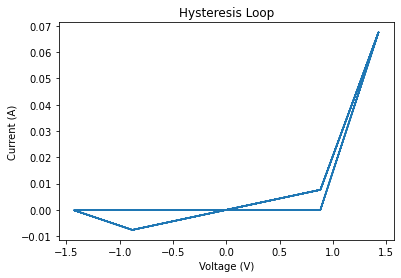

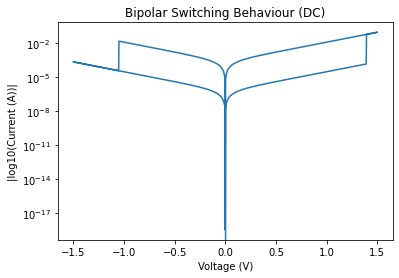

In [60]:
# Reference memristor model

reference_memristor = memtorch.bh.memristor.Stanford_PKU
reference_memristor_params = {'time_series_resolution': 1e-2}
memristor = reference_memristor(**reference_memristor_params)   
memristor.plot_hysteresis_loop()
memristor.plot_bipolar_switching_behaviour()

# **: when define the function, put all keyword arguments into a dictionary for the function to use
#     when call the function, turn the dictionary's key-value pairs into keyword arguments